<a href="https://colab.research.google.com/github/RuwaAbey/Finaly_Year_Project_G09/blob/main/Multihead_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Multi Head Attention**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
sequence_length = 4 #length of the sequence (sentence) "My name is Ruwa"
batch_size = 1 #Parralel processing
input_dim = 512
d_model = 512 #output of the attention unit for every single word
x = torch.randn(batch_size, sequence_length, input_dim)
#Here the x is the input we have just before the multi head attention

In [3]:
x.size()

torch.Size([1, 4, 512])

In [4]:
qkv_layer = nn.Linear(input_dim, 3*d_model)

#Q,K,V Vectors

In [5]:
qkv = qkv_layer(x)

In [6]:
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

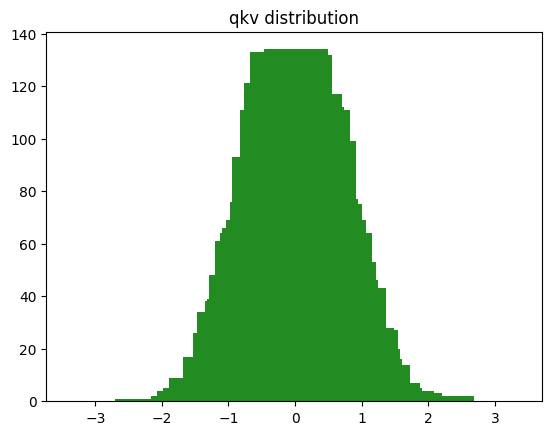

In [7]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = torch.arange(-1,1,0.01)*3
plt.bar(x_val,y_val,align='center',color=['forestgreen'])
plt.title('qkv distribution')
#since we are using random normal distribution this is tha shape we see

In [8]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3*head_dim)

In [9]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [10]:
 #permuation to switch between heads dimention and number of words dimention
 qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3*head_dim]
 qkv.shape

torch.Size([1, 8, 4, 192])

In [11]:
#breaking down this entire tensore torch.Size([1, 4, 8, 192]) by its last dimention dim= -1
#to obtain Q,K, V
q, k, v = qkv.chunk(3,dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

**Self Attention for multiple heads**

For a single head:

$\text{self attention} =\text{softmax} \left(\frac{Q.K^T}{\sqrt{d_k}} + M \right)$

new V = self attention. V



In [12]:
d_k = q.size()[-1] #dimention of K = dimantion of Q

import math
scaled = torch.matmul(q,k.transpose(-2,-1)) / math.sqrt(d_k)
#(-2,-1) - dimension location
scaled.shape
#taking transpose is different than in matrices
#beause they are not 2D

torch.Size([1, 8, 4, 4])

In [13]:
k.T.shape
#this is wht happen when we did it as we did it previosly

<ipython-input-13-cf16f21b9b20>:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  k.T.shape


torch.Size([64, 4, 8, 1])

In [14]:
#example for transpose in tensors
y = torch.randn(2,3)
y

tensor([[ 0.5850,  1.6469,  1.5869],
        [-1.9454,  1.0289,  0.5613]])

In [15]:
torch.transpose(y,0,1)

tensor([[ 0.5850, -1.9454],
        [ 1.6469,  1.0289],
        [ 1.5869,  0.5613]])

In [16]:
torch.transpose(y,1,0)

tensor([[ 0.5850, -1.9454],
        [ 1.6469,  1.0289],
        [ 1.5869,  0.5613]])

In [17]:
k.transpose(-1,-2) == k.transpose(-2,-1)

tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         ...,

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, 

In [18]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal =1)
mask[0][1] #mask for input to a single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [19]:
(scaled + mask)[0][0]

tensor([[-0.5120,    -inf,    -inf,    -inf],
        [ 0.1682,  0.4334,    -inf,    -inf],
        [-0.2740,  0.1605,  0.2413,    -inf],
        [-0.3019, -0.5501, -0.2907,  0.1022]], grad_fn=<SelectBackward0>)

In [20]:
scaled += mask

In [21]:
np.exp(0.5596) / (np.exp(0.5596) + np.exp(0.0404))

0.6269606805367254

In [22]:
attention = F.softmax(scaled, dim=-1)
#applying softmax to last dimention

In [23]:
attention.shape

torch.Size([1, 8, 4, 4])

In [24]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4341, 0.5659, 0.0000, 0.0000],
        [0.2371, 0.3661, 0.3969, 0.0000],
        [0.2331, 0.1819, 0.2358, 0.3492]], grad_fn=<SelectBackward0>)

In [26]:
values = torch.matmul(attention,v)
values.shape

torch.Size([1, 8, 4, 64])

**Full Function**

In [27]:
import math

In [28]:
def scaled_dot_product(q,k,v,mask=None):
  d_k = q.size()[-1]
  scaled = torch.matmul(q,k.transpose(-1,2)) /math.sqrt(d_k)
  if mask is not None:
    scaled += mask
  attention = F.softmax(scaled, dim=-1)
  values = torch.matmul(attention,v)
  return values, attention

In [29]:
values, attention = scaled_dot_product(q,k,v,mask=None)

In [30]:
attention.shape

torch.Size([1, 8, 4, 4])

In [31]:
attention[0][0]

tensor([[0.1239, 0.3416, 0.2164, 0.3181],
        [0.2808, 0.3661, 0.2482, 0.1050],
        [0.1721, 0.2658, 0.2881, 0.2740],
        [0.2331, 0.1819, 0.2358, 0.3492]], grad_fn=<SelectBackward0>)

In [33]:
values.size()

torch.Size([1, 8, 4, 64])

In [34]:
#resize the values so that all the heads are together
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)

In [35]:
values.size()

torch.Size([1, 4, 512])

In [36]:
linear_layer = nn.Linear(d_model, d_model)

In [37]:
out = linear_layer(values)

In [38]:
out.shape

torch.Size([1, 4, 512])

In [39]:
out

tensor([[[-0.0055, -0.1067,  0.1661,  ..., -0.1709, -0.5302, -0.1687],
         [ 0.0678,  0.1473,  0.2780,  ..., -0.1640,  0.2925, -0.0379],
         [-0.0302, -0.2502,  0.0466,  ...,  0.0425, -0.1073, -0.1673],
         [ 0.3162,  0.2657,  0.1599,  ..., -0.1736, -0.0327, -0.0359]]],
       grad_fn=<ViewBackward0>)

In [40]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out


In [42]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)


x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
